# Preprocessing

In [1]:
! pip install sastrawi


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [3]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fajar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fajar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fajar\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
data = pd.read_csv("D:/Kuliah/Semester 8/Portfolio/NLP/dataset_penyisihan_bdc_2024.csv", delimiter=";")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


In [6]:
data.head()

,text,label
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik


In [7]:
print(data['label'].unique())
print(data.label.value_counts())

['Sumber Daya Alam' 'Politik' 'Demografi' 'Pertahanan dan Keamanan'
 'Ideologi' 'Ekonomi' 'Sosial Budaya' 'Geografi']
Politik                    2972
Sosial Budaya               587
Pertahanan dan Keamanan     400
Ideologi                    400
Ekonomi                     367
Sumber Daya Alam            192
Demografi                    62
Geografi                     20
Name: label, dtype: int64


### Stopword dan Lematisasi

In [8]:
# Initialize Sastrawi Stemmer and Stopword Remover
stemmer = StemmerFactory().create_stemmer()
stopwords = set(StopWordRemoverFactory().get_stop_words())

### Cleaning

In [9]:
# Text Cleaning Function
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'http\S+', '', text)  # hapus URL
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # hapus karakter non-alfanumerik
    text = re.sub(r'\s+', ' ', text).strip()  # hapus spasi berlebih
    words = text.split()  # tokenisasi manual
    # hapus stopword dan stemming
    words = [stemmer.stem(word) for word in words if word not in stopwords]
    return ' '.join(words)

data['clean_text'] = data['text'].apply(clean_text)

In [16]:
import re

def is_noise_word(word):
    # Buang kata panjang yang tidak natural
    if len(word) > 20:
        return True

    # Terlalu banyak konsonan berturut-turut
    if re.search(r'[bcdfghjklmnpqrstvwxyz]{5,}', word):
        return True

    # Rasio vokal sangat rendah (< 20%)
    num_vowel = len(re.findall(r'[aeiou]', word))
    if len(word) > 8 and (num_vowel / len(word)) < 0.2:
        return True

    # Campuran huruf dan angka (terlihat seperti hash/id)
    if re.search(r'[a-zA-Z]', word) and re.search(r'\d', word):
        return True

    return False

def remove_noise_words(text):
    
    words = text.split()
    clean_words = [
        word for word in words
        if not is_noise_word(word) and not word.isdigit()
    ]
    return ' '.join(clean_words)

data['clean_text'] = data['clean_text'].apply(remove_noise_words)

In [81]:
data.head()

,text,label,clean_text
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam,kunjung prabowo resmi serah proyek bantu air b...
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik,rt anies tepuk tangan riah jadi rektor wajib m...
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi,emng bener sih dukung yg goblok jg dg dukung h...
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik,rt waktu anies sikap kritis kerja pak prabowo ...
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik,anies baswedan harap asn masuk tni polri pegan...


In [84]:
data.to_csv('data/prepData1.csv', index=False)

# MODEL

In [85]:
dataModel = pd.read_csv("data/prepData1.csv", delimiter=',')

In [73]:
dataModel.isna().sum()

text          0
label         0
clean_text    9
dtype: int64

In [74]:
dataModel = dataModel.dropna(subset=['clean_text'])

### Random Over Sampling

In [75]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(dataModel[['clean_text']], dataModel['label'])

### Padding and Tokenizing

In [76]:
# Tokenization and Padding
MAX_WORDS = 15000  # Vocabulary size
MAX_LEN = 100  # Max length of sequences
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_resampled['clean_text'])

sequences = tokenizer.texts_to_sequences(X_resampled['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

### Label Encode

In [77]:
le = LabelEncoder()
encoded_labels = le.fit_transform(y_resampled)
n_classes = len(le.classes_)

In [78]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, encoded_labels,
    test_size=0.2,
    stratify=encoded_labels,
    random_state=42
)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)

In [79]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Define Improved LSTM Model
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(MAX_WORDS, 256, input_length=MAX_LEN),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, kernel_regularizer=l2(0.01))),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(n_classes, activation='softmax'),

])

# Learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

lstm_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = lstm_model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks = [early_stop])

Epoch 1/15
475/475 [==============================] - 112s 223ms/step - loss: 1.9166 - accuracy: 0.6349 - val_loss: 0.6364 - val_accuracy: 0.8466
Epoch 2/15
475/475 [==============================] - 106s 223ms/step - loss: 0.4825 - accuracy: 0.8909 - val_loss: 0.4251 - val_accuracy: 0.9003
Epoch 3/15
475/475 [==============================] - 112s 235ms/step - loss: 0.3452 - accuracy: 0.9303 - val_loss: 0.4506 - val_accuracy: 0.9021
Epoch 4/15
475/475 [==============================] - 120s 252ms/step - loss: 0.2945 - accuracy: 0.9464 - val_loss: 0.3105 - val_accuracy: 0.9290
Epoch 5/15
475/475 [==============================] - 127s 268ms/step - loss: 0.2092 - accuracy: 0.9606 - val_loss: 0.3266 - val_accuracy: 0.9279
Epoch 6/15
475/475 [==============================] - 128s 270ms/step - loss: 0.1984 - accuracy: 0.9643 - val_loss: 0.2506 - val_accuracy: 0.9455
Epoch 7/15
475/475 [==============================] - 128s 270ms/step - loss: 0.1710 - accuracy: 0.9695 - val_loss: 0.2405 -

KeyboardInterrupt: 

## Evaluasi

In [68]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
# Prediksi kelas (dalam bentuk indeks)
y_pred_probs = lstm_model.predict(padded_sequences)  # prediksi probabilitas
y_pred = np.argmax(y_pred_probs, axis=1)        # ambil indeks probabilitas tertinggi

# Konversi label asli (jika sebelumnya one-hot encoded)
y_true = encoded_labels


156/156 [==============================] - 17s 92ms/step


In [ ]:
# Akurasi keseluruhan
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f"MSE (Mean Squared Error): {mse:.4f}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE (Mean Absolute Error): {mae:.4f}")

# Classification report: precision, recall, f1-score per kelas
target_names = le.classes_  # nama label asli
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))


Accuracy: 0.8501
MSE (Mean Squared Error): 1.1966
RMSE (Root Mean Squared Error): 1.0939
MAE (Mean Absolute Error): 0.3434

Classification Report:
                         precision    recall  f1-score   support

              Demografi       0.00      0.00      0.00        62
                Ekonomi       0.80      0.85      0.83       366
               Geografi       0.00      0.00      0.00        19
               Ideologi       0.88      0.69      0.77       400
Pertahanan dan Keamanan       0.75      0.90      0.82       400
                Politik       0.93      0.91      0.92      2969
          Sosial Budaya       0.68      0.85      0.75       584
       Sumber Daya Alam       0.59      0.53      0.56       191

               accuracy                           0.85      4991
              macro avg       0.58      0.59      0.58      4991
           weighted avg       0.84      0.85      0.84      4991



c:\Users\fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

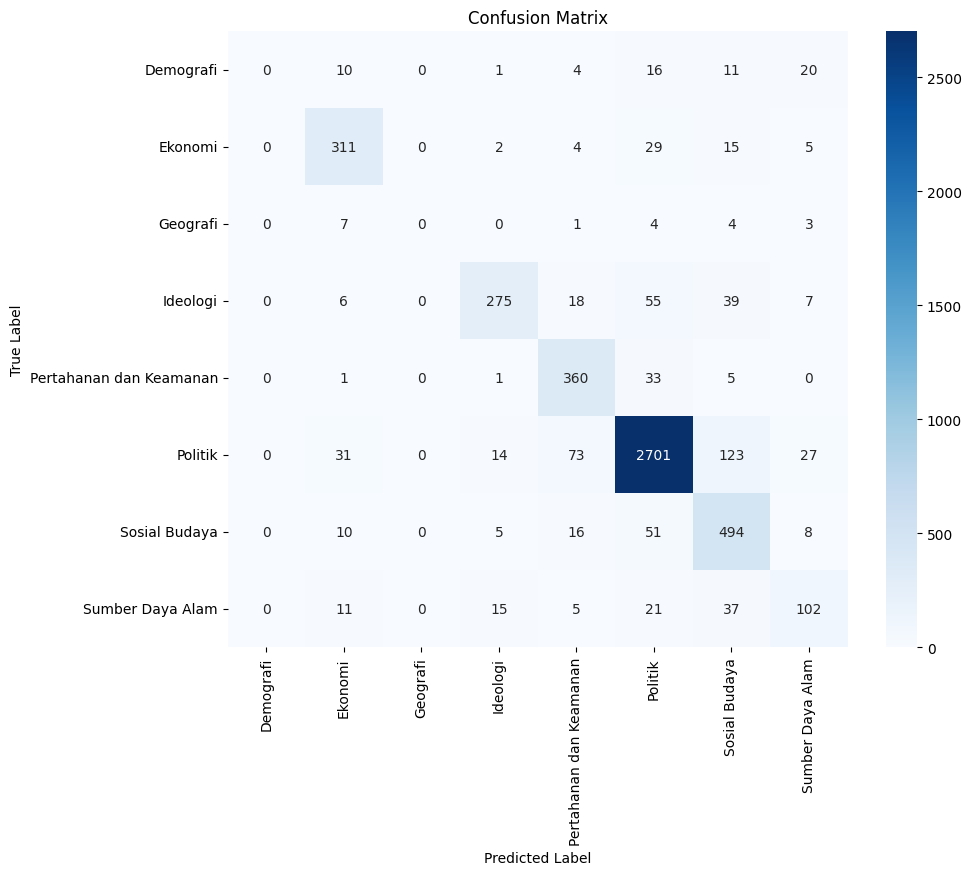

In [71]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
